# The Optimal Statistic and How PTAs detect gravitational waves. 
 Author: Robin Case

Project for GRAVWise.

This project is focused on guiding you through how NANOGrav and other PTAs detect gws. First you will build a statistc to find the amplitude to a sine wave hidden in white noise. This is will help teach you what is happening under the hood in enterprise and enterprise_extensions, the main software packages used by NANOGrav. Then we will shift to looking for the correlation pattern a stochastic gravitational wave background generated by super massive black hole binaries inprints on the residuals of a PTA. 

# Import important packages

In [ ]:
# Increase the resolution of your plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Autoreload is handy if the functions within the imports change between runs. 
# Helpful for development!
%load_ext autoreload
%autoreload 2

#Packages we will use for 2the first part
import numpy as np
import matplotlib.pyplot as2 plt
from scipy.interpolate import interp1d
import os


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


As a first step, let's simulate some data and think about what our likelihood would be. We will be injecting a sine wave as our signal (s), 
$$
s(t,A,f,\phi) = A\sin(2\pi ft + \phi)
$$
Our sine wave has 4 parameters. t represents the time stamps for the data, A is the amplitude of the wave, f is it's frequency, and $\phi$ is the initial phase. Our simulated data will also have white noise which represents error in our measurements. We will draw our white noise from a zero-mean gaussian distribution where the uncertainty is equal to the uncertainty the noise level we set.  
$$
p(n)=\frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{n^2}{2\sigma^2}\right),
$$

In the cell below, choose some settings for your simulated data and plot it! 

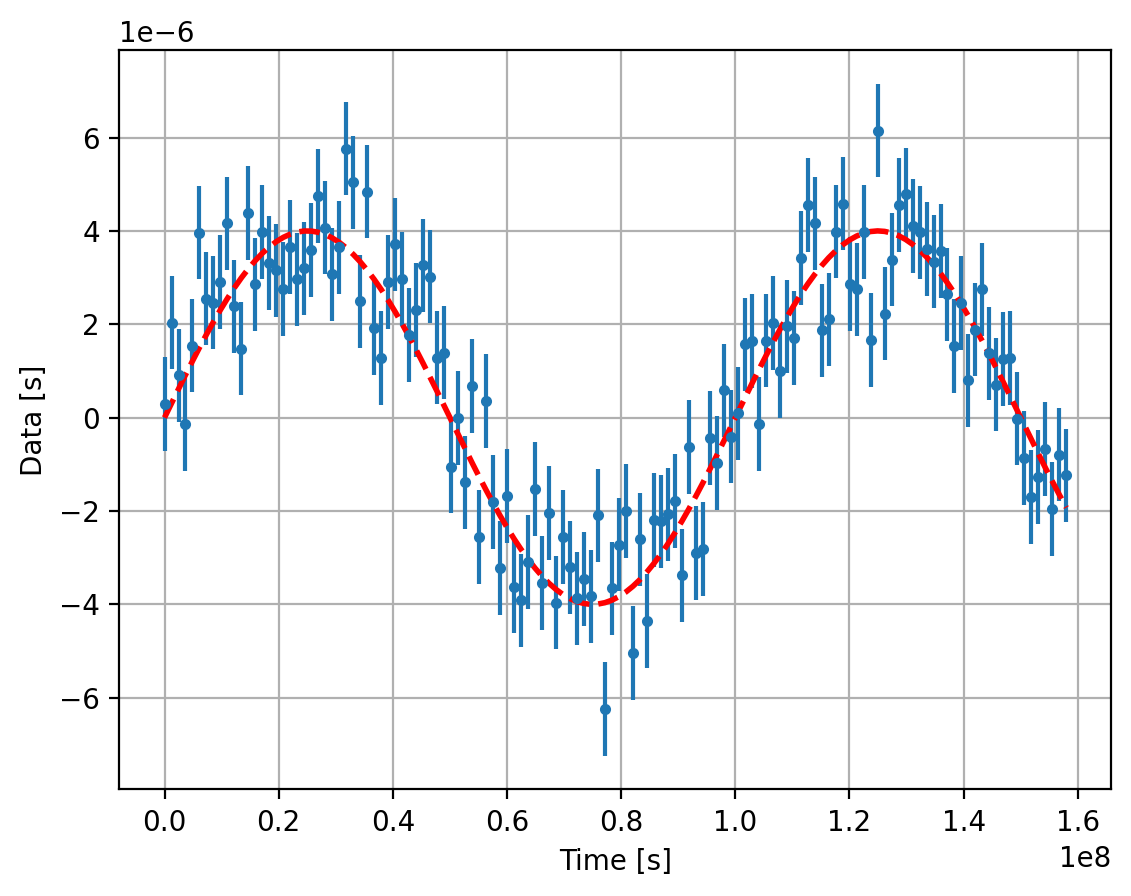

In [ ]:
# Solutions
# simulated data setup
freq = 1e-8
2sigma = 1e-6
phi = 0
t = np.linspace(0, 3.16e7*5, 200)
Amp = 4e-6

# Signal
signal = Amp*np.sin(2*np.pi*freq*t+phi)
#Noise
noise = np.random.normal(0.0, sigma, size=len(t))
#Data = Signal + Noise
data = signal + noise

#plot
plt.errorbar(x=t, y=data, yerr=sigma, fmt='.')
plt.plot(t, signal, lw=2, color='r', ls='--')
plt.xlabel('Time [s]')
plt.ylabel('Data [s]')
plt.grid()

Now let's immediately forget that we just simulated this data. This data was just given to us and we want to find if there is a signal present. The first step is to write down the likelhood of our data. In general we model our data as 

$$\mathrm{data} = \mathrm{signal} + \mathrm{noise}$$

but finding the likelhood of our data can be difficult. We don't know what the signal model exactly is! So how do we find a signal? By modeling our noise!

Let's flip the equation around a bit, 
$$
\mathrm{noise} = \mathrm{data} - \mathrm{signal}
$$
Now this equation is saying, if we subtract out our model for the signal from our data, we should get something that looks like noise. Which by definition is random and can be modeled using a gaussian distribution. 
$$
p(\mathrm{noise})=\frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{\mathrm{noise}^2}{2\sigma^2}\right)
$$
Now let's substitute our equation into this distribution. 
$$
p(\mathrm{d|s})=\frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(\mathrm{data} - \mathrm{signal})^2}{2\sigma^2}\right)
$$

Now we have a likelihood we can evaulate based on the model of our signal! 

Write out what the likelihood would be as a function of d(t), $\sigma$, A, f, t, $\phi$. 

Solution:
$$
p(d|s)=\frac{1}{\sqrt{2 \pi \sigma^2}}\exp\left[-\frac{(d(t)-s(A, f, \phi))^2}{2\sigma^2}\right].
$$

$$
p(d|s)=\frac{1}{\sqrt{2 \pi \sigma^2}}\exp\left(-\frac{[d(t)-A\sin(2\pi f t + \phi)]^2}{2\sigma^2}\right).
$$

# Parameter Estimation of the Amplitude

How the optimal statistic works is by maximizing the log likelihood ratio of the likelihood when there is a signal present in our data divided by the likelihood the signal was purly noise. In practice we write the log likelihood ratio as,
$$
\log\Lambda=(d|s)-\frac{1}{2}(s|s),
$$
(Can you derive this?) where the notation around $(d|s)$ stands for the inner product between the two time vectors.  The inner product is defined as: 
$$(x|y)=\sum_i x_iy_i/\sigma^2$$

Write out some functions to calculate the inner product, and compute the inner products for the log likelihood ratio. Also write a function to compute the log likelihood ratio!

In [22]:
# Solution
def innerProduct(x, y, sigma):
    """
    Computes the noise weighted inner product
    of between two time vectors x and y. If data is d and template is s
    each with N samples, then the inner product is

    :param x: x time series
    :param y: y time series
    :param sigma: standard deviation of noise

    :returns: noise weighted inner product
    """
    return np.dot(x, y)/sigma**2

def LogLikelihood(data, signal, sigma):
    '''
    Computes the log likelhood ratio between the data and the signal model. 

    :param data: data time series
    :param signal: signal time series
    :param sigma: standard deviation of the noise
    
    :returns: log likelihood ratio 
    '''
    return innerProduct(data, signal, sigma) - 0.5 * innerProduct(signal, signal, sigma)

For the OS, want to find the amplitude for your signal function that maximizes the likelhood. This is known as the maximum likehood estimate for the amplitude. Let's rewrite our signal function, 
$$s(t)=A\sin(2\pi f t + \phi) = A \tilde{s}(t)$$
Where $\tilde{s}(t)$ now holds the sine wave information. I like to think of this amplitude-less as the signal template you are searching for in the data. 

Now I want you to find the optimal estimator for the ampltiude by maximizing the log likelihood ratio with respect to the amplitude. 

Hint: To let's maximize the likelihood ratio for the amplitude you'll need to do this:

$$0 = \frac{\partial \log\Lambda}{\partial A} $$

Once you have the optimal estimator, write out some code to find it!


Solution:

$$
\log\Lambda=A(d|\tilde{s})-\frac{A^2}{2}(\tilde{s}|\tilde{s})
$$

$$
\hat{A}=\frac{(d|\tilde{s})}{(\tilde{s}|\tilde{s})}
$$

In [23]:
#  maximum likelihood estimator for A
def maxLikeA(data, signal_template, sigma):
    return innerProduct(data, signal_template, sigma)/innerProduct(signal_template, signal_template, sigma)

Great! now we need to find the uncertatinty on that estimator! Fortunately there is a general formula for the uncertainty, 
$$
\sigma_{x}^2 = \langle x^2 \rangle -\langle x \rangle^2 
$$
where the angle brackets represent the average. In our case, the maximum likelihood estimator is the average! Find what the uncertainty for our optimal estimator and write out the code for it. Is the MLE within one uncertainty of the true value?


Solution
$$
\sigma_{\hat{A}}^2 = \langle \hat{A}\hat{A} \rangle -\langle \hat{A} \rangle^2 = \frac{1}{(\tilde{s}|\tilde{s})},
$$

In [24]:
#  maximum likelihood std for A
def sigma_maxLikeA(signal_template, sigma):
    return np.sqrt(1/innerProduct(signal_template, signal_template, sigma))

In [25]:
signal_template =1*np.sin(2*np.pi*freq*t+phi)
Ahat = maxLikeA(data, signal_template, sigma)
sigma_Ahat = sigma_maxLikeA(signal_template, sigma)
print(f'MLE Amplitude: {Ahat} +/- {sigma_Ahat}')
print(f'True Amplitude: {Amp}')

MLE Amplitude: 3.9130739148214296e-06 +/- 1.2712464872645642e-07
True Amplitude: 4e-06


Congratulations! You just wrote your first optimal estimator! Now let's check how this looks on a graph. Rewrite your log likelihood function to take in a range of amplitudes and see where you landed.

In [34]:
# function to create sine wave
def gen_signal(t=None, A=None, f=1e-8, phi=0):
    """
    Return a sinusoid with amplitude A and frequency f and phase phi, 
    sampled at times t.

    :param t: Time samples
    :param A: Amplitude of sine wave
    :param f: Frequency of sine wave
    :param phi: phase of sine wave

    :returns: sine wave at specified t, A, phi and f
    """
    return A*np.sin(2*np.pi*f*t + phi)
# likelihood function
def LogLikelihood(data, t, A, f, sigma):
    sig = gen_signal(t=t, A=A, f=f)
    return innerProduct(data, sig, sigma) - 0.5 * innerProduct(sig, sig, sigma)

Text(0, 0.5, 'p(d|s)')

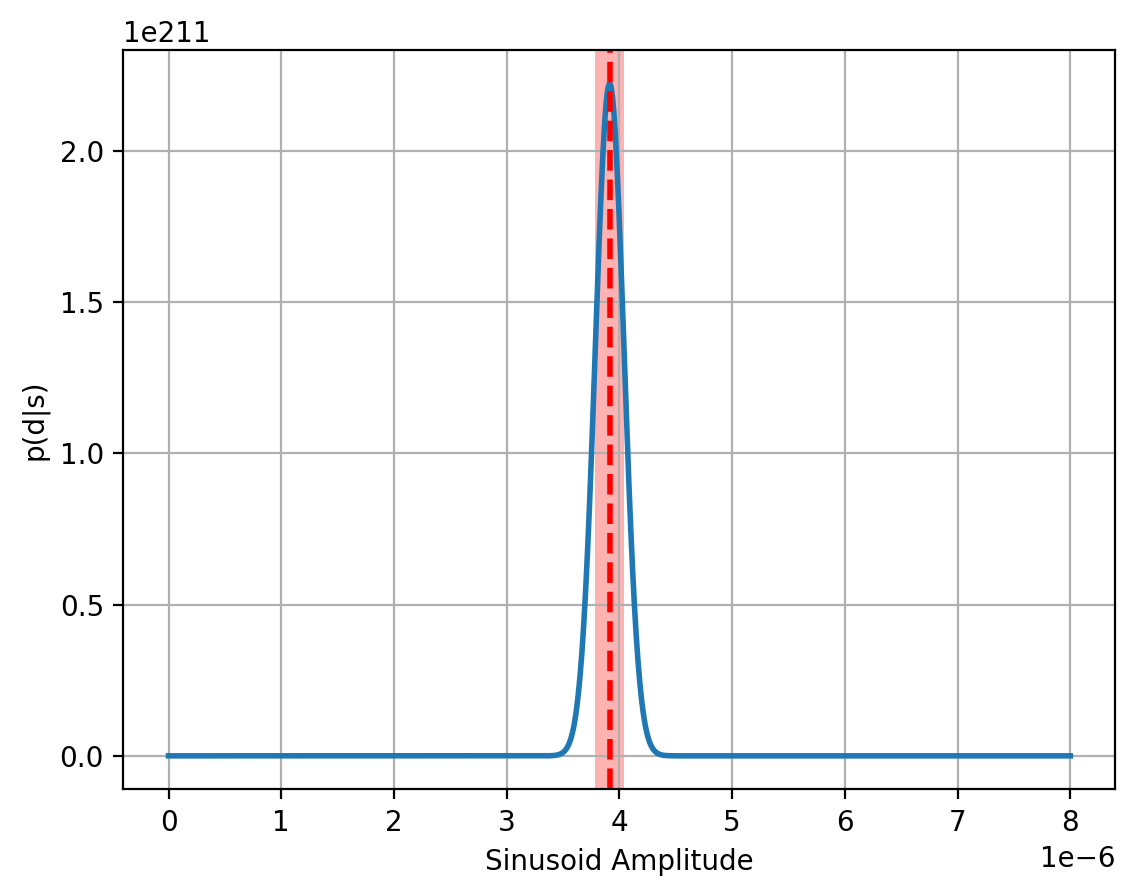

In [36]:
N = 1000
Amps = np.linspace(0, 8e-6, N)
llike = np.zeros(N)
for ii in range(N):
    llike[ii] = LogLikelihood(data, t, Amps[ii], freq, sigma)

like = np.exp(llike)/(np.sqrt(2*np.pi*sigma**2))
plt.plot(Amps,like, lw=2)
plt.axvline(Ahat, color='r', lw=2, ls='--')
plt.axvspan(Ahat-sigma_Ahat,Ahat+sigma_Ahat, facecolor='r',alpha=0.3)
plt.grid()
plt.xlabel('Sinusoid Amplitude')
plt.ylabel('p(d|s)')

But that's the likeilhood which is the probablily we get our data given the signal $p(d|s)$ what about the posterior, $p(A|d)$(Probablily of A given our data.)? This is typically the distribution we are interested in looking at since it will tell us how often we expect to find this amplitude  Find the posterior distribution, find the maximum-a-postori (peak of the distribution but also referred to as MaP) for the amplitude, and plot everything with the true amplitude marked as a vertical line. 

Hint: You'll need to use Bayes theroem with a uniform prior.
$$
\log p(A|d) \propto \log p(d|s) + \log p(A)
$$
Where p(A) is the prior distribution for the amplitudes. 
This prior must be normalized to 1, so if our prior is uniform which means that each value of A has an equal probablility, thus $p(A)=C$, where $C$ is a constant. 
Integrate this uniform prior to determine the normalization constant (i.e., use $\int p(A)dA=1$ to find the value of $C$).
Also the posterior distribution needs to be normalized to one. You can do this by dividing the posterior you get by the sum total of the posterior. 


Solution
$$p(A) = \frac{1}{A_{\mathrm{max}} - A_\mathrm{min}}$$

$$p(A|d) = \frac{p(d|s)}{A_{\mathrm{max}} - A_\mathrm{min}} $$


MAP value for A = 3.915915915915916e-06 +/ 1.2712464872644766e-07
True value of A = 4e-06


Text(0, 0.5, 'p(A|d)')

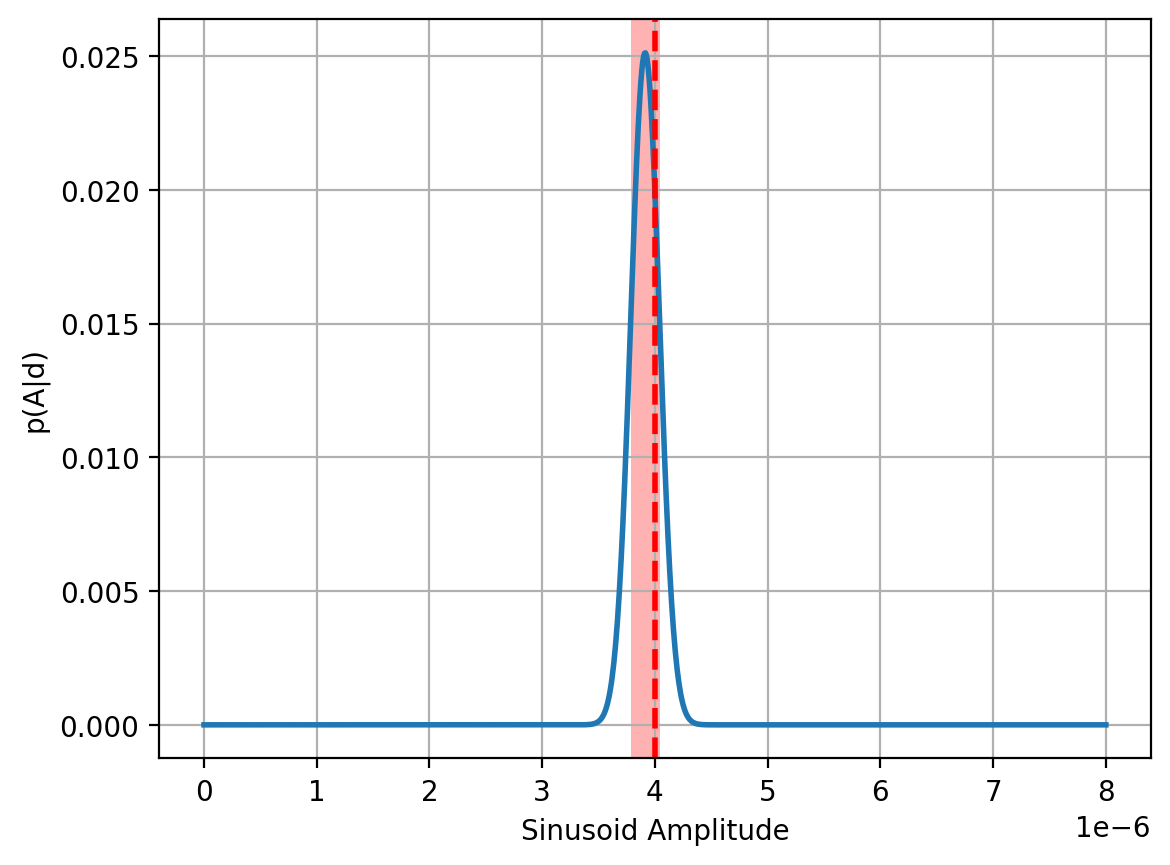

In [38]:
N = 1000
Amps = np.linspace(0, 8e-6, N)
llike = np.zeros(N)
for ii in range(N):
    llike[ii] = LogLikelihood(data, t, Amps[ii], freq, sigma)

post = np.exp(llike) / (Amps.max()-Amps.min())  
mapA = Amps[np.argmax(post)]
p = post/post.sum()
stdA = np.sqrt(np.sum(Amps**2*p) - np.sum(Amps*p)**2)
print('MAP value for A = {0} +/ {1}'.format(mapA, stdA))
print('True value of A = {0}'.format(Amp))
plt.plot(Amps, p, lw=2)
plt.axvline(Amp, color='r', lw=2, ls='--')
plt.axvspan(mapA-stdA,mapA+stdA, facecolor='r',alpha=0.3)
plt.grid()
plt.xlabel('Sinusoid Amplitude')
plt.ylabel('p(A|d)')

Once you get to this point, come find me and I can help onboard you for the next part. This was a lot of math that is happening under the hood for the optimal statistic in enterprise. For this next part we will look at pulsar timing arrays as a detector and the signal they are trying to find. 

# Pulsar timing Arrays and Gravitational waves

First, let's talk about gravitational waves. These are minute ripples in space and time. When a gravitational wave passes by, it will briefly contract one axis, while elongating another. Gravitational waves are transverse waves, meaning they propagate perpindicular to the distortions they make. Imagine a ring of masses and there is a gravitational wave going through your screen. The gravitational wave will perturb the test masses bringing them in closer or farther away (See diagram below):

![Test ring of masses](https://www.researchgate.net/profile/Alexander-Lukanenkov/publication/301303751/figure/fig1/AS:668973389598737@1536507093911/As-a-gravitational-wave-passes-perpendicular-to-a-ring-of-test-mass-it-will-distort-the.png)

There are two modes that the gravitational wave perturbs the ring. We call thes emodes plus and cross modes since that is the directions of the different ossilations. The amount the ring gets perturbed is what we call the "strain" of the gravitational wave. These waves don't only perturb space, they also perturb time! 

Now let's talk about pulsars for a moment, these are rapidly spinning neutron stars that emit a beam of radiation from their magnetic poles. The radiation is visible in the radio and x ray bands of light.  As the star rotates, if the beam is in our line of sight, we will see the pulsar as a consistent flashing radio source. These stars are approximately the mass of the sun, but the size of Manhatten, rotating anywhere between 1 revolution a second to 1000 times a second. The faster the star is spinning, the more stable the period of rotation (Why is this true?). These stars act as galactic clocks that if we time the periods of carefully, we can do a lot of cool science!

This is why NANOGrav and other PTAs observe millisecond pulsars (pulsars spinning ~1000 times a second) to detect gravitational waves. When a gravitational wave passes by, it will distort the distance the pulsar slightly and cause the a red-shift in the pulse frequency. This red shift is what PTAs are trying to detect, however, the distance to pulsars are not well known and there is interstellar medium in the way. The interstellar medium causes dispersion (Photon changing frequency)and scattering (Absorption and Reemission) of the photon as it travels to Earth. To get around this, PTAs look at a correlated signal between pulsar pairs. 

![Pulsars](https://s3-us-west-2.amazonaws.com/courses-images/wp-content/uploads/sites/1095/2016/11/03170543/OSC_Astro_23_04_Pulsar.jpg)

Let's think about the test ring again for a moment as if it is our PTA. Imagine you put Earth in the center and the rings are pulsars. As the gravitational wave passes the detector, the adjacent pulsars will be distorted in similar ways to one another while pulsars perpindicular to one another will be distorted a lot. There is a clear pattern that the different pulsar pairs wil oscillate with depending on the mode of the gravitational wave. This correlation pattern was first derived in 1983 by R.W Hellings and G.S Downs (https://articles.adsabs.harvard.edu/pdf/1983ApJ...265L..39H) and is the smoking gun for gravitational wave detection in PTAs. 

There are multiple sources of gravitational waves that PTAs and other detectors like LIGO and LISA can detect. The main two sources of gravitational waves that NANOGrav is likely to detect are Continuous Waves and the Stochastic Gravitational Wave Background. A continuous wave will look like a sine wave in a pulsar timing array data set. You already built a simple version of the F statistic that will find these waves. For the rest of this project we will be considering a stochastic gravitational wave background as our source and work with the tools within enterprise (NANOGrav's software package) to try and detect this signal. 

You might be thinking, what is the stochastic background? The stochastic background is the superposition of gravitational wave signals emitted across the cosmos. Astrophysically we think the strongest signal will be from super massive black hole binaries. These black holes are on the order of millions to billions times the mass of the sun. We know that at the center of each galaxy is a super massive black hole. We also know through hubble and james webb space telecopes that almost every galaxy is in a state of merging with another one. Therefore it stands to reason there should be a large number of thes super massive black hole binaries as well, but they haven't been observed yet. If there was a binary large enough and close enough to Earth, it would peak over the background at its orbital frequency.

Now let's start trying to look for a stochastic background! First let's look at the HD curve, the smoking gun for the stochastic background. In the cell below take the hellings and downs curve, make a function that takes in angles in radians and returns $\Gamma_{ab}$,

$$
\Gamma_{ab} = \frac{1}{2} - \frac{1-\cos{\xi_{ab}}}{4} \left[ \frac{1}{2} - 3 \ln \left( \frac{1-\cos{\xi_{ab}}}{2} \right) \right],
$$

Then plot it over a range of angular seperations between pulsar pairs ab, $\xi_{ab}$.

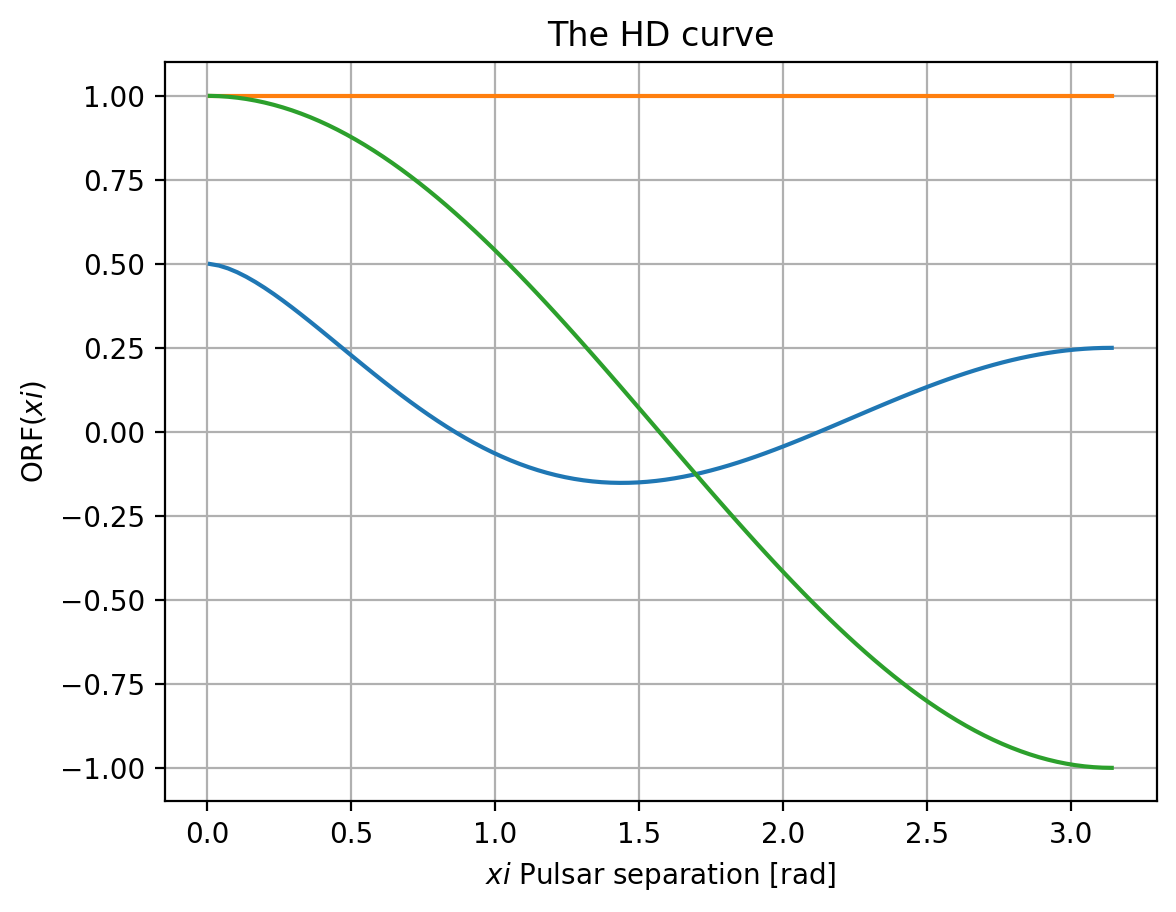

In [39]:
def HD_ORF(xi):
    c = (1-np.cos(xi))/2
    return (1/2) - (c/2)*( (1/2) - 3*np.log(c) )
def Monopole_ORF(xi):
    return np.ones(len(xi))

def Dipole_ORF(xi):
    return np.cos(xi)

# Lets test it!
xi_range = np.linspace(0.01,np.pi,100)
# My function supports vectorization!
HD_curve = HD_ORF(xi_range)
Dipole_curve = Dipole_ORF(xi_range)
Monopole_curve = Monopole_ORF(xi_range)
plt.plot(xi_range,HD_curve, label = 'HD')
plt.plot(xi_range,Monopole_curve, label = 'Monopole')
plt.plot(xi_range,Dipole_curve, label = 'Dipole')
plt.xlabel('$xi$ Pulsar separation [rad]')
plt.ylabel('ORF($xi$)')
plt.title('The HD curve')
plt.grid()
plt.show()

This is the signal we are going to be looking for! Side Note: There are other correlations that might look like a gravitaional that are important to check for. What I mean is that there is a common process that we see in different pulsar pairs. Physically only a gravitaional wave will induce pulsar pair correlations. These other correlations are the monopole and dipole correlations. These correlations arise either through a mistake in our timing model for the pulsars (monopole) or errors in the solar system barycenter (General Relativity version of for center of mass). For fun add these correlations to the above plot. 

$$
\Gamma_{ab}^{\mathrm{Mono}} = 1
$$

$$
\Gamma_{ab}^{\mathrm{Dip}} = \cos{\xi_{ab}}
$$

Now let's load in some data! Load in the HD sim psrs dataset in the Data directory and plot a pulsars residuals using plt.errobar(). The data is saved as a pickle file which is a saved list of pulsar objects. These objects store the data/information for the pulsar that enterprise will use to look for the correlated signal. The main data product for PTAs are the times of arrivals (TOAs) and the residuals. TOAs are the time stamps of when we observed a pulse from a pulsar. Residuals are what is left over after subtracting the timing model from the obseved TOAs. The timing model involves everything we know about the pulsar. It's proper motion, position in the sky, distance to Earth, dispersion measure etc. Ideally, once we subtract out the timing model all that should be left is either white noise or the stochastic background. 

To get information out the pulsar object you call the object, type a period, call the thing in the object you want. For example if I want a pulsars residuals I would want do something like, object.residuals. For your plot you will need residuals, toas, and the toaerrs. 

<ErrorbarContainer object of 3 artists>

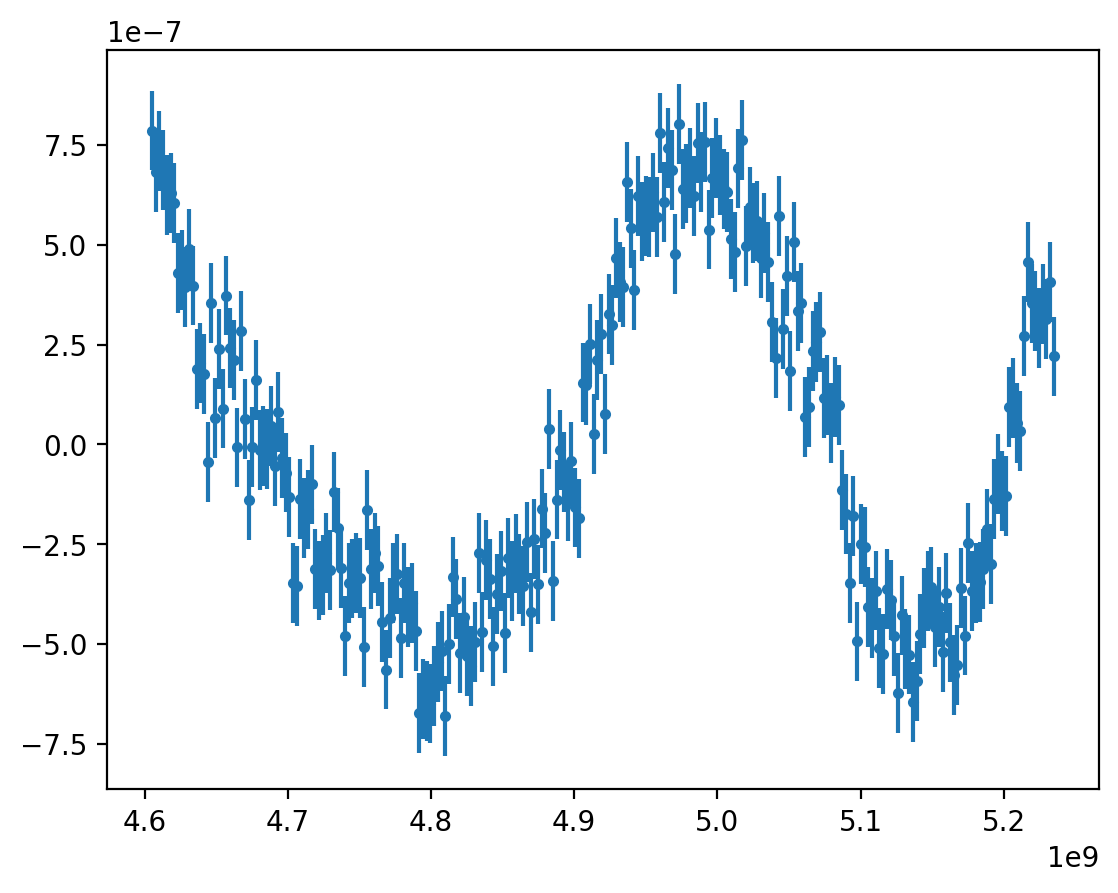

In [ ]:
# Lets load up the pulsars
import pickle
with open('../case_PTAs_OS/Data/simulated_ptas/pta1/369.pkl','rb') as f:
    psrs = pickle.load(f)
 

# Since this is a simulated dataset, I happen to know the injected amplitude!
true_amplitude = 2e-15

psr_idx = 6
plt.errorbar(x= psrs[psr_idx].toas, y = psrs[psr_idx].residuals, yerr=psrs[psr_idx].toaerrs, fmt = '.', zorder = 0) 

Now we want to model the signal. In this simulated dataset there is white noise and a common "red" noise process. "White" and "red" refer to the power of the noise across different frequencies. White noise is flat across frequencies, while red noise has more power at lower frequencies than at higher frequencies. White noise is noise from the radio telecope recievers. For this dataset, the white noise power can be thought of as,

$$P_{\mathrm{wn}} = 2 \bar{\sigma}^2 dt$$ 

where $\bar{\sigma}$ is the average uncertanty of the TOAs and dt is the observation cadence. This is a simplistic model for the white noise that holds when we have an even cadence to the TOAs. In reality we will have gaps in the data due to periods where we are not observing the pulsar. 

The common red noise process is typically modeled as a power law with two hyper model parameters $A$ and $\gamma$, Where A is the amplitude of the GW (related to the strain) and $\gamma$ is the spectral index. For a background produced by super massive black hole binaries, $\gamma = 13/3$
$$
P_\mathrm{rn} = \frac{A^2}{12 \pi^2}\left(\frac{f}{f_\mathrm{yr}}\right)^{-\gamma} f^{-3}
$$
 
Plot the power spectral density for a pulsar as a function of frequency on a log-log plot. $f_\mathrm{yr}$ is the $1/\mathrm{yr}$ and I injected a signal with an amplitde of $2e-15$. For your frequencies, we typically bin our frequencies in bins of $1/T_{\mathrm{obs}}$. I would make the frequencies like this:

freqs =  np.arange(1/Tobs, (f_bins + .001)/Tobs, 1/Tobs)

You will need to find the observation time of the PTA. (Hint: Look at the TOAs!).

In [74]:
# Solution
from enterprise_extensions import model_utils
Tspan = model_utils.get_tspan(psrs)
yr_in_sec = 365.25*24*3600
def spectrum(f_bins = 30, tspan = 20*yr_in_sec, gamma = None):
    freqs =  np.arange(1/tspan, (f_bins + .001)/tspan, 1/tspan)
    f_ref = 1/yr_in_sec
    if np.all(gamma):
        return 1/(12 * np.pi**2 * freqs**3) * (freqs/f_ref)**(3 - gamma) 
    else:
        raise TypeError("Only powerlaw PSDs with defined gammas are allowed!")

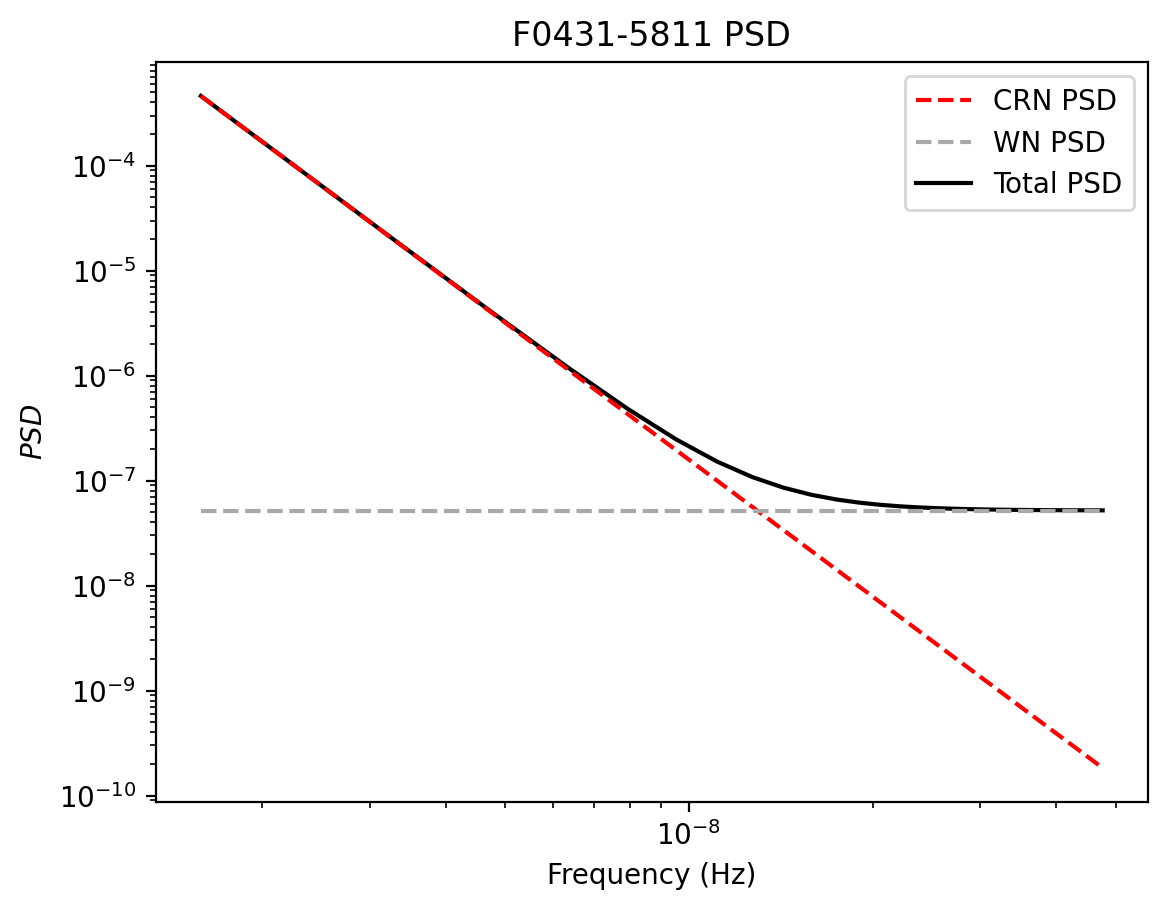

In [73]:
psr_idx=10
gw_psd = true_amplitude**2*spectrum(f_bins = 30, gamma = 13/3)
wn_sigma = psrs[psr_idx].toaerrs[0]*np.ones(len(freqs))
dt = psrs[psr_idx].toas[1] - psrs[psr_idx].toas[0]
wn_psd = 2*wn_sigma**2*dt
freqs = np.arange(1/Tspan, (30 + .001)/Tspan, 1/Tspan)
plt.plot(freqs, gw_psd , label = 'CRN PSD', color = 'red', ls = '--')
plt.plot(freqs, wn_psd , label = 'WN PSD', color = 'darkgrey', ls = '--')
plt.plot(freqs, gw_psd + wn_psd, label = 'Total PSD', color = 'black', ls = '-', zorder = 0)
plt.legend(loc = 'upper right')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$PSD$')
plt.title(f'{psrs[psr_idx].name} PSD')
plt.show()

Now for realistic data, there is more to consider with the white noise and red noise. Pulsars may also have intrinsic red noise to consider. This is red noise that is only seen in that specific pulsar. These can arise to spin variations in the pulsar or profile changes. For now we don't have to worry about that but if you are working with a real dataset, you will need to consider intrinsic red noise! 

Now let's constuct this model in enterprise. I will provide the different pieces that you will need. You will need to add in the specifics 

In [75]:
# Imports for PTA modeling
import enterprise
from enterprise_extensions import models 
from enterprise_extensions.model_utils import get_tspan
from enterprise_extensions import blocks

# La_forge for loading in chains!
from la_forge.core import Core

# The actual optimal statistic
from enterprise_extensions.frequentist.optimal_statistic import OptimalStatistic


In [ ]:
# Solution
Tspan = get_tspan(psrs)
# These are the different types of white noise that NANOGrav characterizes. For our dataset we only have the toa errors. 
# #Efac is a "extra factor" that gets multiplied to the toa errors and Equad is any extra noise that is added in quadrature. 
# Since we only have uncertainty in our TOAs we can set Efac to 1 and log_10 equad to -infinity.  
efac = models.parameter.Constant(1.0)
equad = models.parameter.Constant(-np.inf)

# How enterprise works is by making these "blocks" for the model. This is the white noise block and will model 
# the white noise in the pulsar object given efac and equad
wn = models.white_signals.MeasurementNoise(efac=efac,log10_t2equad=equad)

# We have a common process in our data, so we want to model it! this can be done with the common red noise block. 
# We want to use a power law PSD with a gamma_value of 13/3. 
# An important note, there is an arguement in this function called "orf".
# If you wanted to model a specific set of correlations, you would change this to the ORF you want. 
# For now, we want to model just a common red noise process and use the OS to find the signal. 
curn = blocks.common_red_noise_block(psd='powerlaw',
                                     Tspan=Tspan, 
                                     components=5, # Number of GWB frequencies to analyze
                                     gamma_val=13./3.,
                                     name='gw_crn')
# If we wanted to model the intrinsic red noise, we would include this block!
irn = blocks.red_noise_block(Tspan=Tspan,components=5) # Number of IRN frequencies to model

#Last but not least, we want to include the timing model.
tm = models.gp_signals.TimingModel(use_svd=True)

# Construct the model for our signal!
model = tm + wn + curn 

# Once you have the modle you can make the PTA object that we will use to analyze for a SGWB!
pta = models.signal_base.PTA([model(psr) for psr in psrs])

The next step would be to load up a sampler, and do a Bayesian parameter estimation. If you want to look at how to setup a sampler in enterprise I've provided some code for you to do so. For now, we can load in the results I already generated for us. 

In [ ]:
to_sample = False

if to_sample:
    # Sample the PTA
    # We can use a fancy sampler setup from enterprise extensions!
    from enterprise_extensions.sampler import setup_sampler

    chain_loc = 'make/dir/for/chain/'

    # Setup_sampler will add some extra jump proposals to make things easier
    sampler = setup_sampler(pta,chain_loc,resume=True,human='KAG')

    # We need an initial sample
    x0 = np.hstack([p.sample() for p in pta.params])

    # Sample the posterior.
    sampler.sample(x0, Niter=int(1e6))

    # With things sampled, we need to grab the chain itself.
    # We can use la_forge to simplify things!
    lfcore = Core(chaindir=chain_loc)
    
    lfcore.save('make/dir/for/core.core')

else:
    # No need to sample, instead, we can just grab our pre-ran chains!

    chain_dir = "../case_PTAs_OS/Chains/enterprise/simulated_ptas/r369/"
    pta_core = Core(chain_dir)


Let's check our chain! The chain are random samples taken by the MCMC to maximize the likelihood and the result is a posterior for parameter that was sampled for. In our model we only have 2 parameters that we are looking for. The amplitude and spectral index of the common processin our pulsars. There are some extra parameters in the chain however. These are lnpost, lnlike, chain accept, and pt_chain accept. The lnpost and lnlike are the log posterior and log liekhoods for our model. chain accept and pt_chain_accept is how often the sampler accepted a given step. You can ignore the last 4 parameters. What we care about, and what the OS will care about is the spectral index and the amplitude. 

Plot the posteriors from the chain!

You can easily call the chain of a core object with core.chain. Also make a dictionary of the maximum a posterior of the parameters in chains. To check the pars you can look at core.params. 
Hint: the la_forge package has a diagnostics script that makes plotting these chains easy!

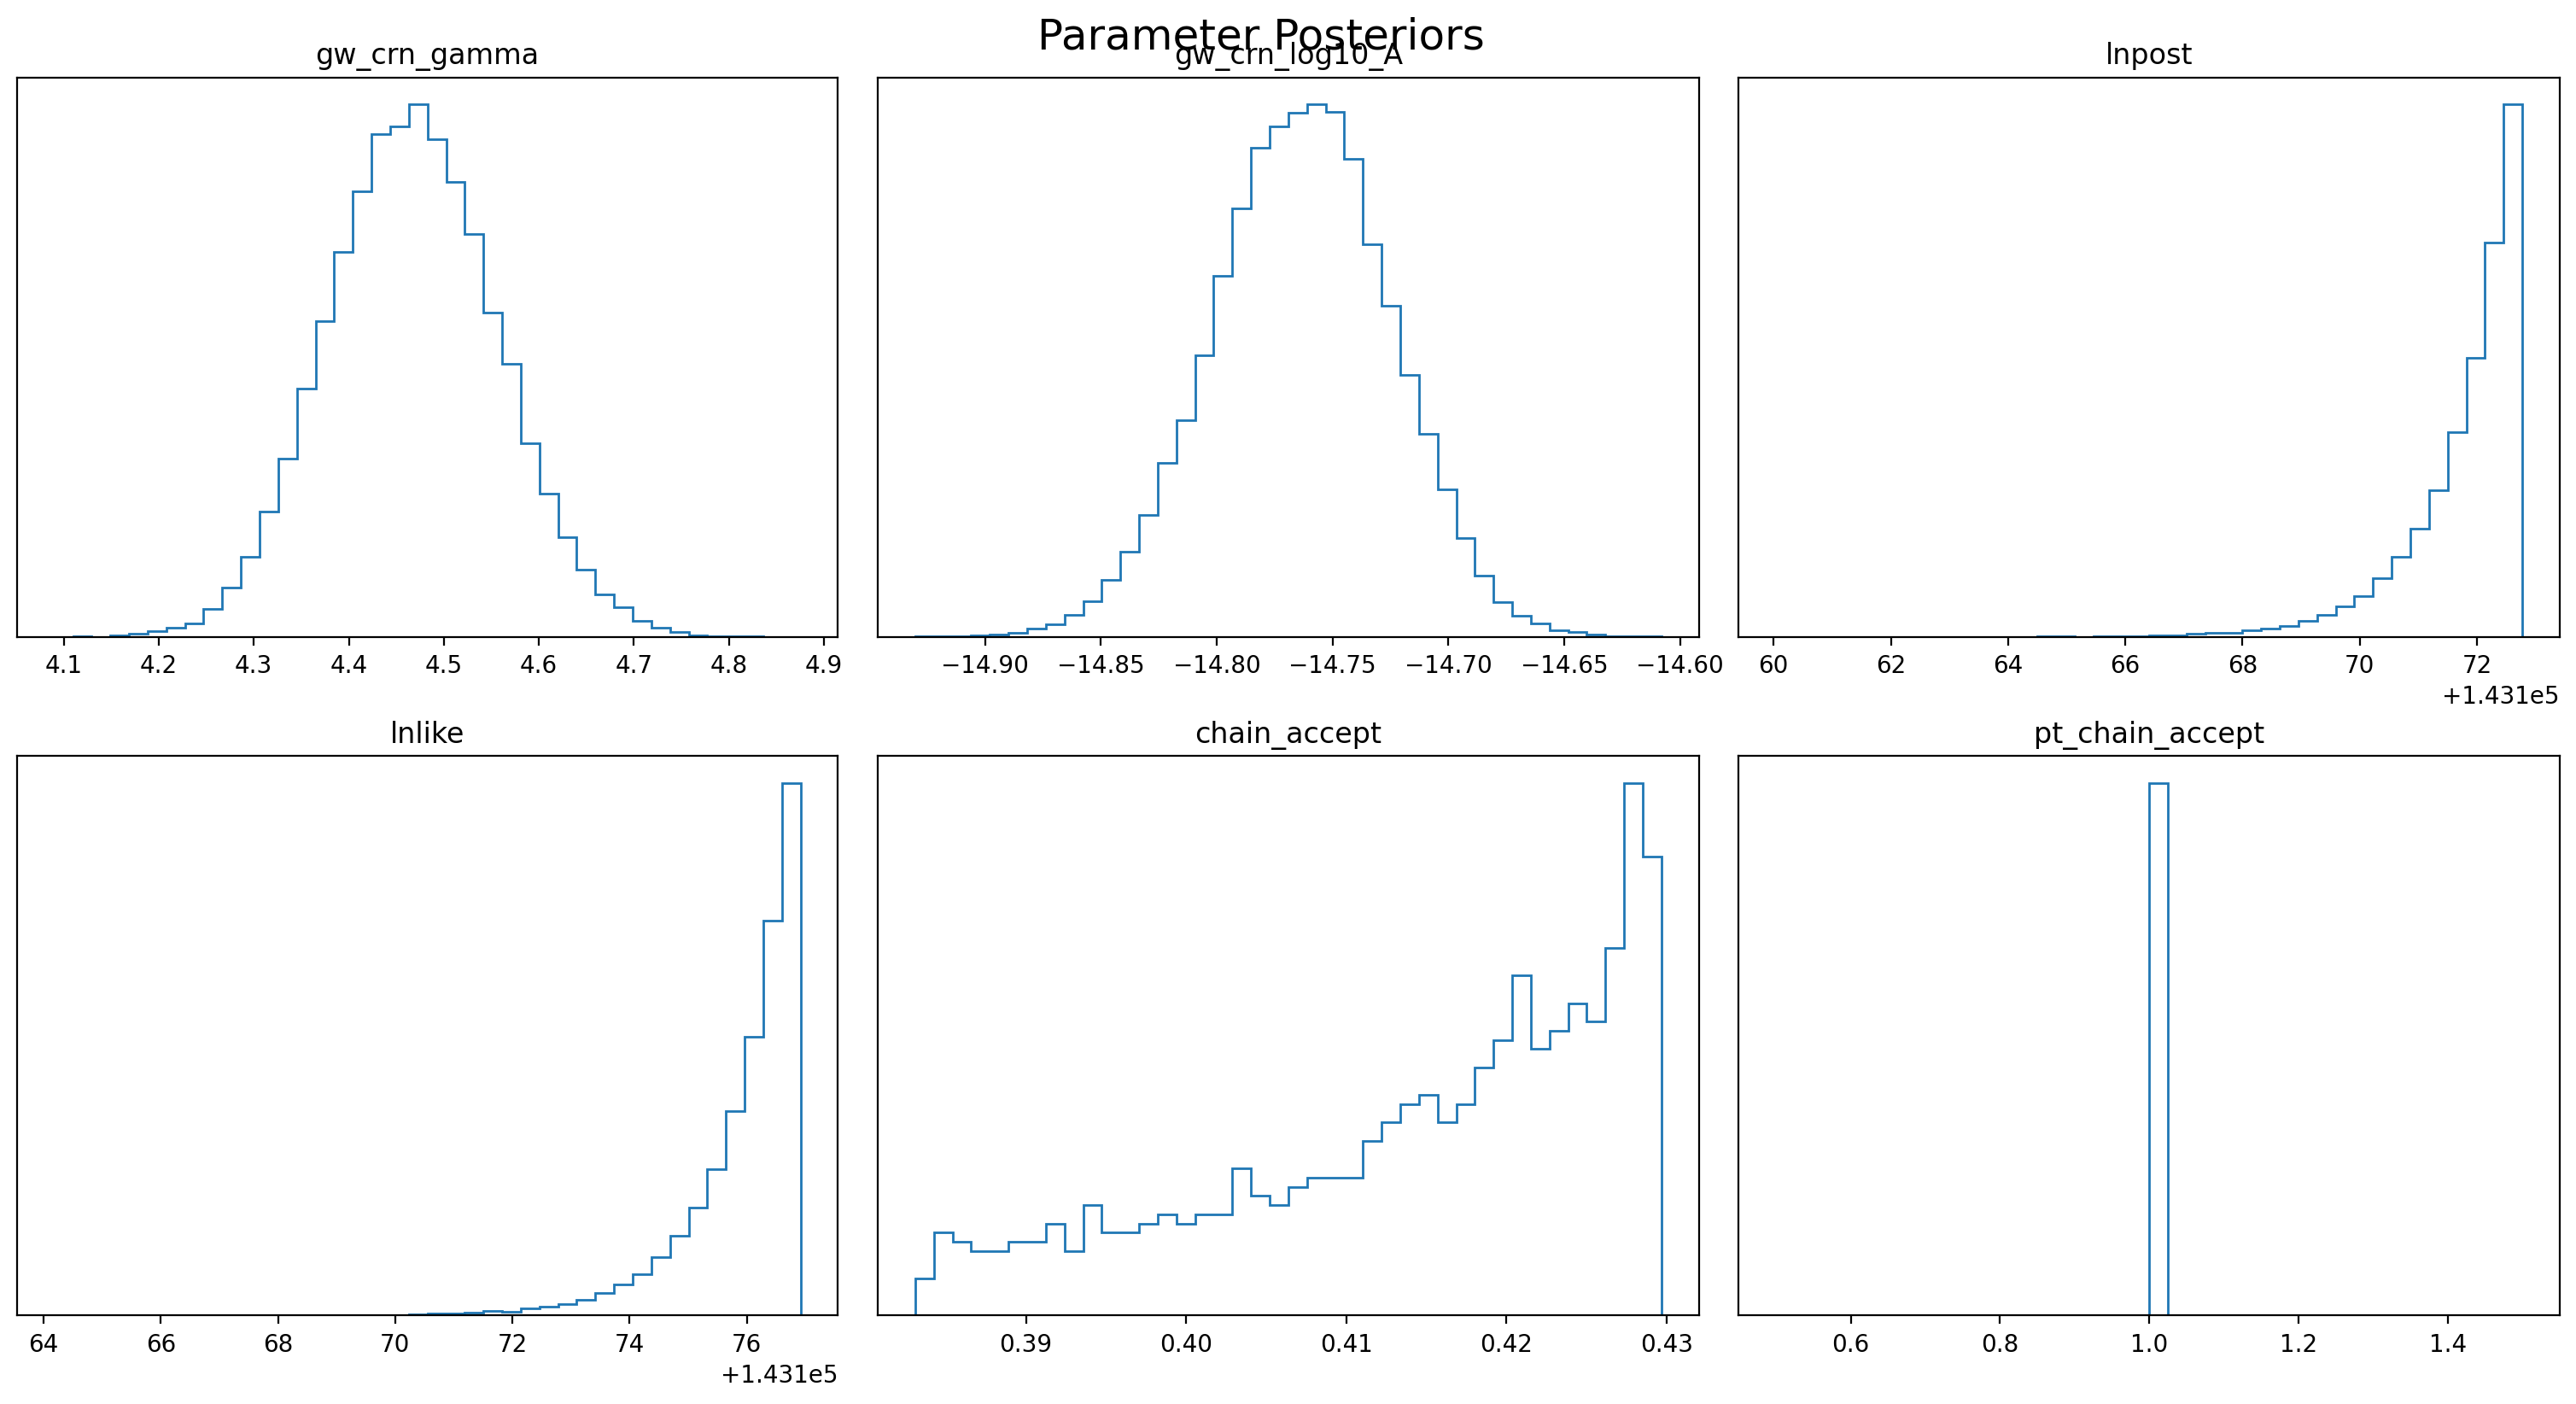

In [86]:
from la_forge import diagnostics as dg
map_dict = pta_core.get_map_dict()
dg.plot_chains(pta_core)


Now we are ready to make an optimal statistic object in enterprise and look for correlations in the residuals! The optimal statistic for PTAs takes the likelihood ratio of when we have correlations in our data vs when we have 0 correlations, and then maximizes the log likeliood ratio for the amplitude of the correlations. (Sound familiar?). This ends up being equivalent to minizing the variance of a $\chi^2$ distribution. (Which ends up being an easier derivation!)

Ca you to derive the OS Amplitude and uncertainty estimates? For this you will want to minmize this $\chi^2$ distribution with respect to the gravitational wave amplitude.
$$
\chi^2 = \sum_{IJ} \left(\frac{\rho_{ab} - A_{\mathrm{gw}}^2 \Gamma_{ab}^2}{\sigma_{ab}}\right)
$$
The correlated power between pulsar pairs is given by,

$$\rho_{ab} = \frac{r_a^T P_a^{-1} \tilde{S}_{ab} P_{b}^{-1} r_b }{\mathrm{Tr} \left[P_a^{-1} \tilde{S}_{ab} P_b^{-1} \tilde{S}_{ba}\right]}$$
With an uncertainty of, 
$$\sigma_{ab} =\left(\mathrm{Tr} \left[P_a^{-1} \tilde{S}_{ab} P_b^{-1} \tilde{S}_{ba}\right]\right)^{-\frac{1}{2}}$$

In these equations, $r_a$ are the residuals. $P_a^{-1}$ is the covariance matrix that describes the power of pulsar a. The covariance matrix is the fourier transform of the power in the frequency domain. (If you're curious it is found through the Wiener-Khinchin Theorem). $\tilde{S}_{ab}$ is the cross covariance matrix and describes the correlated power between the pair. Like $P_a^{-1}$ it is the fourier transform of the power, but only of the correlated signal. The value of the HD curve is multipled by the fourier transorm. This is our signal template! (like $\tilde{s}$) from before!  If you attempt this leave the ampltiude and uncertainty estimates as functions of the correlated power and uncertanties. 



Solution
$$
\hat{A}^2 = \frac{\sum_{ab} \frac{\rho_{ab}\Gamma_{ab}}{\sigma_{ab}^2}}{ \sum_{ab} \frac{\Gamma_{ab}^2}{ \sigma_{ab}^2} }
$$

$$
\sigma_0^2 = \left(\sum_{ab} \frac{\Gamma_{ab}^2}{\sigma_{ab}^2}\right)^{-1}
$$


If you get stuck on this, don't worry! Try to move on to this next part so we can get a signal to noise ratio!

Make an OS object and compute the "noise maximized OS" for this dataset and print out the amplitude with the uncertainty. You will need to input the pulsar list, the ORF and PTA into the OptimalStatistic() function we uploaded earlier. 

Once you make the object, you can compute the OS using OS_object_you_made.compute_os(param_dictionary). The OS will use the PTA object to make the model/covaraince matrices for the pulsars and look for the correlations you want based on the dictionary you provide. 

The output of the OS will be:
- $\xi_{ab}$
    - The vector of pulsar pair separations
- $\rho_{ab}$
    - The vector of $\rho_{ab}$ correlated powers
- $\sigma_{ab}$
    - The vector of $1-\sigma$ standard deviation in $\rho_{ab}$
- $\hat{A}^2$
    - The mean $\hat{A}^2$ of the Gaussian fit on the GWB amplitude square
- $\sigma_0$
    - The $1-\sigma$ standard deviation of the $\hat{A}^2$ mean

In [107]:
# Solution
OS_obj = OptimalStatistic(psrs, orf='hd', pta=pta)
xi,rho,sig,A_hat_2,A_hat_2s = OS_obj.compute_os(map_dict)
print(f'{A_hat_2} +/- {A_hat_2s}')


3.273161982310736e-30 +/- 2.536695878439012e-31


The power of the OS is that it can be used as detection statistic by giving us the correlations and a signal to noise ratio.To get the signal to noise ratio take your $\hat{A}^2$ and divide it by the uncertainty $\sigma_0$. What is the signal to noise ratio of the data set?

You can also get a Z-score for the signal using $Z = {|\hat{A}^2 - A_{\mathrm{true}}|}{\sigma_0}$. This will tell you how many sigma's the signal is from a zero mean gaussian. The higher the score, the stronger the signal. What is the Z score of your dataset?

In [113]:
# Solution
print(f'Max likelihood OS SNR =',A_hat_2/A_hat_2s)

# And also the Z score 
# (i.e. number of sigma the recovery is from the injection)
print(f'Max likelihood OS Z-score =',np.abs(A_hat_2-true_amplitude**2)/A_hat_2s)

Max likelihood OS SNR = 12.903249499206494
Max likelihood OS Z-score = 2.86529427459997


Now how do the correlations look? We appear to have a signal, but is it the one what we are looking for? Plot the correlated power with the uncertainties. Include the Hellings and Downs curve so you can compare. 

You may notice that there are a bunch of correlations, too many to actually say we are following the expected pattern. Here is a function to help clean up your plot! the binned pair correlations function will bin the pairs across the sky so that the plot is cleaner. 

In [114]:

def binned_pair_correlations(xi, rho, sig, bins=10):
    """Create binned separation vs correlations with even pairs per bin.

    This function creates a binned version of the xi, rho, and sig values to better
    vizualize the correlations as a function of pulsar separation. This function uses
    even number of pulsar pairs per bin. Note that this function only works with continuous 
    ORFs in pulsar separation space.

    Args:
        xi (numpy.ndarray): A vector of pulsar pair separations
        rho (numpy.ndarray): A vector of pulsar pair correlated amplitude
        sig (numpy.ndarray): A vector of uncertainties in rho
        bins (int): Number of bins to use. Defaults to 10.

    Returns:
        xiavg (numpy.ndarray): The average pulsar separation in each bin
        rhoavg (numpy.ndarray): The weighted average pulsar pair correlated amplitudes
        sigavg (numpy.ndarray): The uncertainty in the weighted average pair amplitudes
    """
    temp = np.arange(0,len(xi),len(xi)/bins,dtype=np.int16)
    ranges = np.zeros(bins+1)
    ranges[0:bins]=temp
    ranges[bins]=len(xi)
    
    xiavg = np.zeros(bins)
    rhoavg = np.zeros(bins)
    sigavg = np.zeros(bins)
    
    #Need to sort by pulsar separation
    sortMask = np.argsort(xi)
    
    for i in range(bins):
        #Mask and select range of values to average
        subXi = xi[sortMask]
        subXi = subXi[int(ranges[i]):int(ranges[i+1])]
        subRho = rho[sortMask]
        subRho = subRho[int(ranges[i]):int(ranges[i+1])]
        subSig = sig[sortMask]
        subSig = subSig[int(ranges[i]):int(ranges[i+1])]
        
        subSigSquare = np.square(subSig)
        
        xiavg[i] = np.average(subXi)
        rhoavg[i] = np.sum(subRho/subSigSquare)/np.sum(1/subSigSquare)
        sigavg[i] = 1/np.sqrt(np.sum(1/subSigSquare))
    
    return xiavg, rhoavg, sigavg

<>:20: SyntaxWarning: invalid escape sequence '\G'
<>:20: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_4048216/2963490614.py:20: SyntaxWarning: invalid escape sequence '\G'


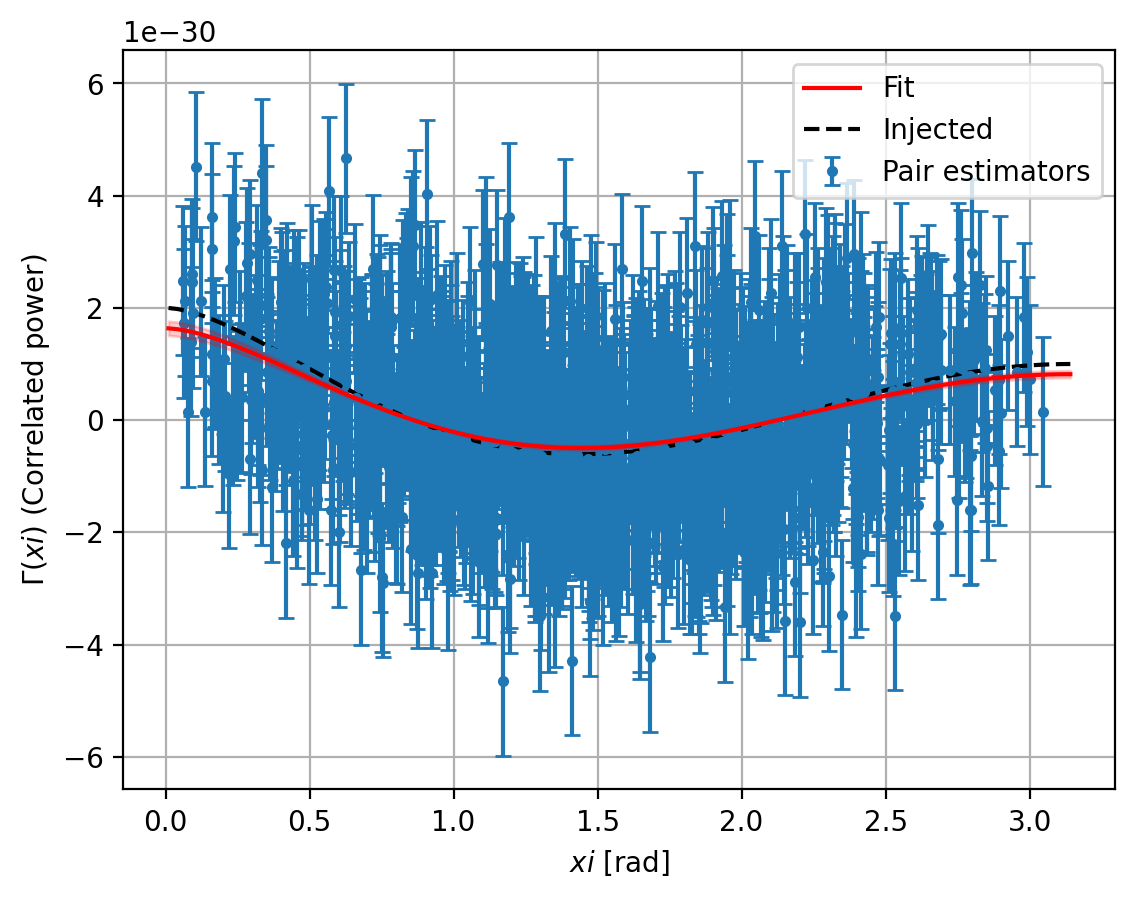

In [115]:
# Solution
# Plot the pair correlated powers!
plt.errorbar(x=xi, y=rho, yerr=sig, fmt='.', capsize=3,label='Pair estimators')

# Now lets plot our model. Remember we fit A^2 * HD(xi) so lets plot that!
plt.plot(xi_range, A_hat_2*HD_curve,'-r',label='Fit',zorder=100) 

# We can also plot our 1-sigma error bars on A!
plt.fill_between(xi_range, (A_hat_2-A_hat_2s)*HD_curve, 
                 (A_hat_2+A_hat_2s)*HD_curve,
                 color='r',
                 alpha=0.2,
                 zorder=100)


# Now finally, lets plot the true amplitude
plt.plot(xi_range, true_amplitude**2*HD_curve,'--k',label='Injected')

plt.xlabel('$xi$ [rad]')
plt.ylabel('$\Gamma(xi)$ (Correlated power)')
plt.legend()
plt.grid()
plt.show()

<>:15: SyntaxWarning: invalid escape sequence '\G'
<>:15: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_4048216/503875224.py:15: SyntaxWarning: invalid escape sequence '\G'


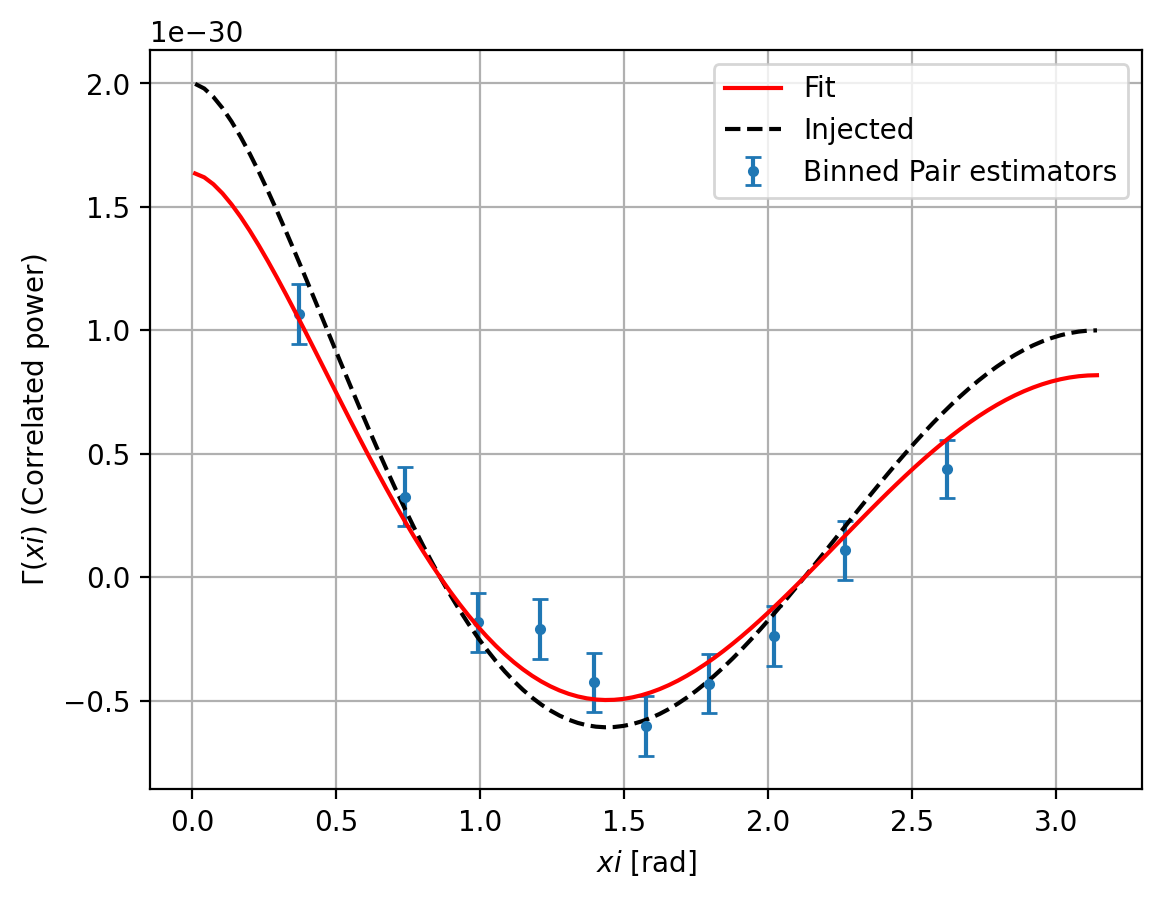

In [116]:
# Solution
# Get the binned representation
xi_bin, rho_bin, sig_bin = binned_pair_correlations(xi, rho, sig, bins=10)

# Plot the pair correlated powers!
plt.errorbar(x=xi_bin, y=rho_bin, yerr=sig_bin, fmt='.', capsize=3,label='Binned Pair estimators')

# Now lets plot our model. Remember we fit A^2 * HD(xi) so lets plot that!
plt.plot(xi_range, A_hat_2*HD_curve,'-r',label='Fit',zorder=100) 

# Now finally, lets plot the true amplitude
plt.plot(xi_range, true_amplitude**2*HD_curve,'--k',label='Injected')

plt.xlabel('$xi$ [rad]')
plt.ylabel('$\Gamma(xi)$ (Correlated power)')
plt.legend()
plt.grid()
plt.show()

The last step we can do is to do a noise marginalized version of the OS. You can do this by calling compute_noise_marginalized_os from your opt_stat_object. You need to feed it a chain with only the parameters that are in your models and a list of the parameters in the chain. You can call the chain by calling the core object with core.chain. Then to cut off the last 4 entries with this syntax chain[:-4]. 

The noise marginalized OS will compute the OS by taking random draws from your chain, rather than a single value. This gives you a distribution of OS values that you can use and will typically be unbiased by the sampler.

Compute the noise marginalized opitmal statistic and plot the distribution of the signal to noise ratio. Note that the marginalized OS doens't return the uncertainty of the amplitude estimate, but the signal to noise ratio directly. If you want the uncertainty you will have to rearrange the Signal to noise ratio equation. 

In [ ]:
# SOlution
os_chain = pta_core.chain[:-4] # We need to cut off the diagnostic chains (i.e. likelihood, posterior, etc.)
# You can check which parameters are diagnostics by inspecting lfcore.params

os_chain_names = pta_core.params[:-4]

# The number of noise draws N is generally going to be between 1-10 thousand
# the goal is to have a stable distribution! (ask me what it means to be stable)
# this function doesn't have a progress bar, so it may take some time!
xi,nm_rho,nm_sig,nm_A2,nm_SNR = OS_obj.compute_noise_marginalized_os(os_chain,os_chain_names,
                                                                     N=1000)

# This cell took about a minute for me

/home/atrius/miniconda3/envs/ng20/lib/python3.12/site-packages/enterprise_extensions/frequentist/optimal_statistic.py:221: UserWarning: MCMC chain does not have the same number of parameters as the model.
  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:23<00:00, 11.98it/s]


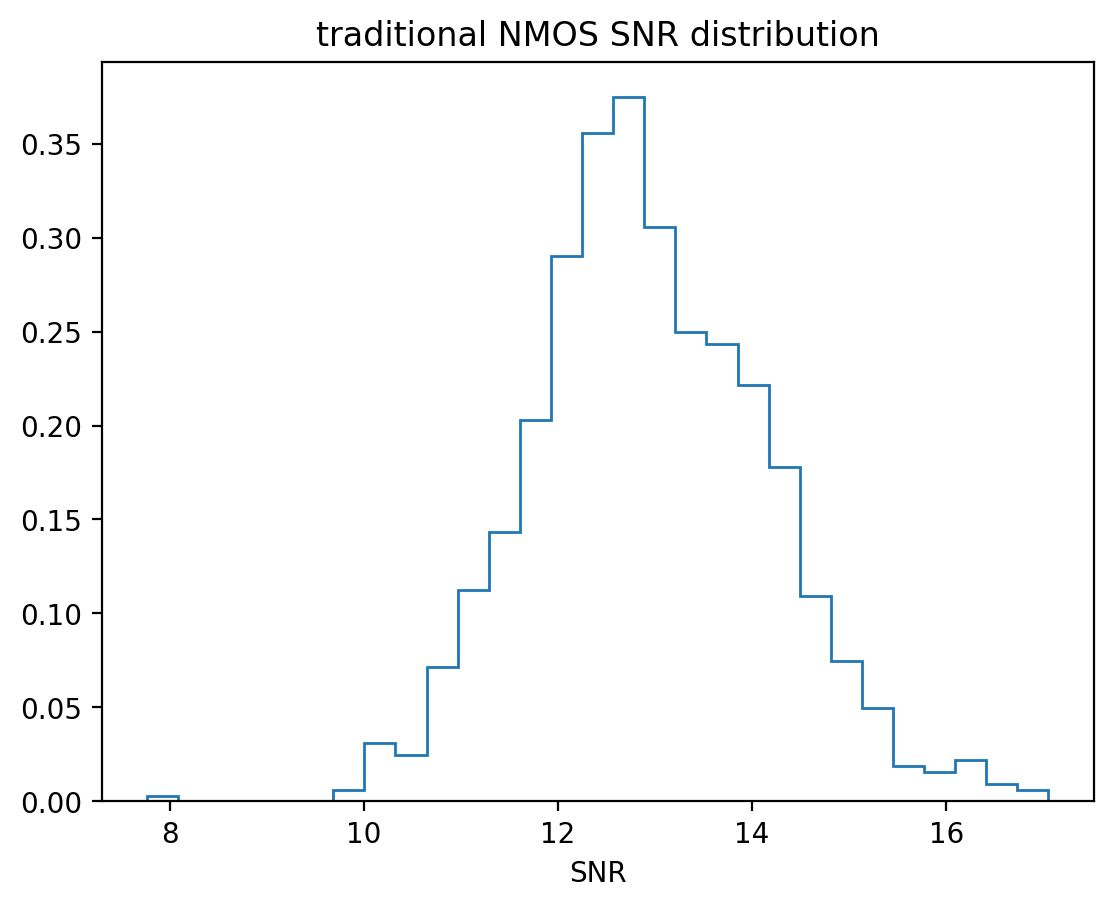

In [118]:
# Solution
nm_A2s = nm_A2/nm_SNR
plt.hist(nm_SNR,bins='auto',histtype='step',density=True)
plt.xlabel('SNR')
plt.title('traditional NMOS SNR distribution')
plt.show()

# Congratulations! You just detected a gravitational wave in the simulated dataset!